# General Framework

## What's the story?
* I was in high school attending public school in downtown Chicago. I remember sometimes being afraid of civil unrest, especially surrounding high-profile court cases and during COVID-19. I remember experiencing teacher strikes, crazy winter storms, and other volatile activity, thinking: is it still safe to take the L blue line train to school today?

## What data will I use?
I will use the GDELT database to identify violent events. Specifically, I will pull events with the code **145X** from the GDELT Event Database. We'll first review it and then decide how to build our model.


In [22]:
%pip install db-dtypes


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip show google-cloud-bigquery


Name: google-cloud-bigquery
Version: 3.27.0
Summary: Google BigQuery API client library
Home-page: https://github.com/googleapis/python-bigquery
Author: Google LLC
Author-email: googleapis-packages@google.com
License: Apache 2.0
Location: /Users/warrenweissbluth/Library/Python/3.9/lib/python/site-packages
Requires: google-api-core, google-auth, google-cloud-core, google-resumable-media, packaging, python-dateutil, requests
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install google-cloud-bigquery


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.cloud import bigquery
import pandas as pd

# Initialize BigQuery client with the project ID
client = bigquery.Client(project="civil-unrest-predictor")

# SQL query
query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
ORDER BY
    SQLDATE DESC
LIMIT
    100;
"""

# Execute the query
query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Save the results to a CSV file
data.to_csv("chicago_violent_protests_subset.csv", index=False)
print("Results saved to 'chicago_violent_protests_subset.csv'")
data


Results saved to 'chicago_violent_protests_subset.csv'


,SQLDATE,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,20241206,145,"Chicago, Illinois, United States",41.8500,-87.6501,1.066667
1,20241202,145,"University Of Chicago, Illinois, United States",41.7898,-87.5998,-0.843289
2,20241202,145,"Chicago, Illinois, United States",41.8500,-87.6501,-7.840083
3,20241202,145,"University Of Chicago, Illinois, United States",41.7898,-87.5998,-0.843289
4,20241118,145,"Chicago, Illinois, United States",41.8500,-87.6501,-6.067678
...,...,...,...,...,...,...
95,20240821,145,"Chicago, Illinois, United States",41.8500,-87.6501,-7.349081
96,20240821,145,"Chicago, Illinois, United States",41.8500,-87.6501,-5.176460
97,20240821,145,"Chicago, Illinois, United States",41.8500,-87.6501,-7.038863
98,20240821,145,"Chicago, Illinois, United States",41.8500,-87.6501,-5.474138


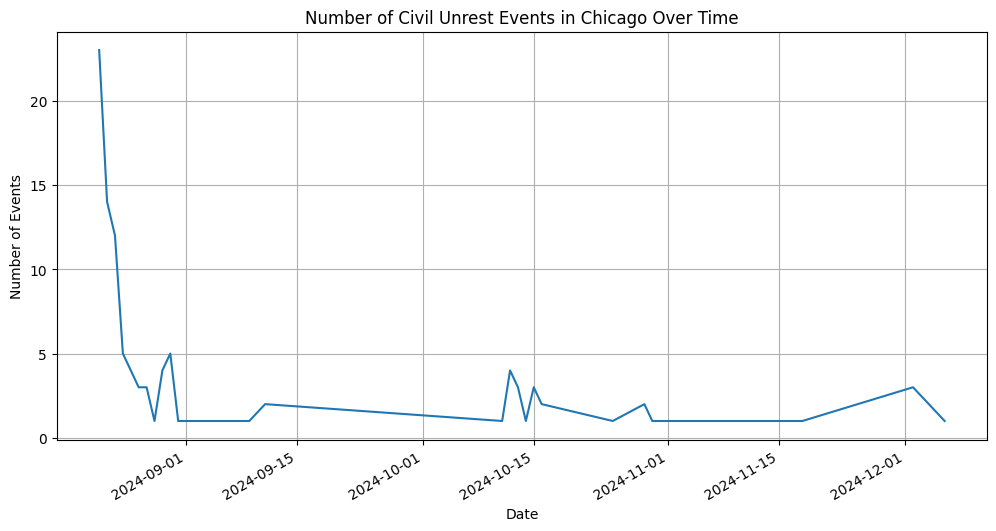

In [ ]:
import matplotlib.pyplot as plt

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Plot the number of events over time
plt.figure(figsize=(12, 6))
data.groupby('SQLDATE').size().plot(kind='line')
plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

In [ ]:
# Updated SQL query to pull data from January 2020 and limit to 2000 rows
query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20200101'
ORDER BY
    SQLDATE DESC
LIMIT
    2000;
"""

# Execute the updated query
query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Save the results to a CSV file
data.to_csv("chicago_violent_protests_jan2020_subset.csv", index=False)
print("Results saved to 'chicago_violent_protests_jan2020_subset.csv'")
print(data.head())

Results saved to 'chicago_violent_protests_jan2020_subset.csv'
    SQLDATE EventCode                              ActionGeo_FullName  \
0  20241206       145                Chicago, Illinois, United States   
1  20241202       145  University Of Chicago, Illinois, United States   
2  20241202       145                Chicago, Illinois, United States   
3  20241202       145  University Of Chicago, Illinois, United States   
4  20241118       145                Chicago, Illinois, United States   

   ActionGeo_Lat  ActionGeo_Long   AvgTone  
0        41.8500        -87.6501  1.066667  
1        41.7898        -87.5998 -0.843289  
2        41.8500        -87.6501 -7.840083  
3        41.7898        -87.5998 -0.843289  
4        41.8500        -87.6501 -6.067678  


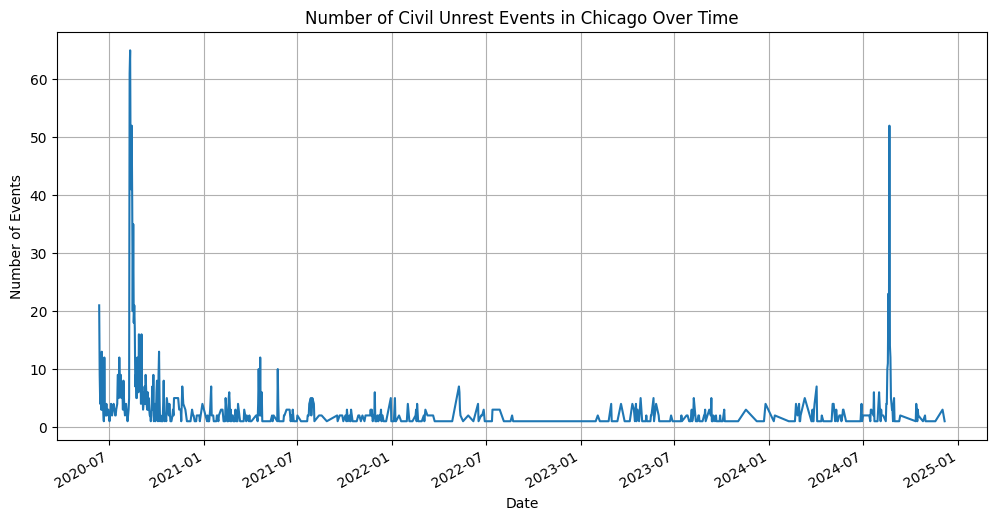

In [ ]:
import matplotlib.pyplot as plt

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Plot the number of events over time
plt.figure(figsize=(12, 6))
data.groupby('SQLDATE').size().plot(kind='line')
plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

In [29]:
# Updated SQL query to pull data from 2015 to today
query = """
SELECT
    SQLDATE,
    EventCode,
    ActionGeo_FullName,
    ActionGeo_Lat,
    ActionGeo_Long,
    AvgTone
FROM
    `gdelt-bq.full.events`
WHERE
    EventCode IN ('145', '1451', '1452', '1453', '1454')
    AND ActionGeo_FullName LIKE '%Chicago%'
    AND CAST(SQLDATE AS STRING) >= '20150101'
ORDER BY
    SQLDATE DESC;
"""

# Execute the updated query
query_job = client.query(query)

# Convert results to a DataFrame
data = query_job.result().to_dataframe()

# Convert SQLDATE to datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'], format='%Y%m%d')

# Split the data into training and testing datasets
train_data = data[data['SQLDATE'] < '2021-01-01']
test_data = data[data['SQLDATE'] >= '2021-01-01']

# Save the results to CSV files
train_data.to_csv("chicago_violent_protests_train.csv", index=False)
test_data.to_csv("chicago_violent_protests_test.csv", index=False)

print("Training data saved to 'chicago_violent_protests_train.csv'")
print("Testing data saved to 'chicago_violent_protests_test.csv'")
print("Training data:")
print(train_data.head())
print("Testing data:")
print(test_data.head())

Training data saved to 'chicago_violent_protests_train.csv'
Testing data saved to 'chicago_violent_protests_test.csv'
Training data:
       SQLDATE EventCode                ActionGeo_FullName  ActionGeo_Lat  \
977 2020-12-29       145  Chicago, Illinois, United States          41.85   
978 2020-12-29       145  Chicago, Illinois, United States          41.85   
979 2020-12-29       145  Chicago, Illinois, United States          41.85   
980 2020-12-29       145  Chicago, Illinois, United States          41.85   
981 2020-12-24       145  Chicago, Illinois, United States          41.85   

     ActionGeo_Long   AvgTone  
977        -87.6501 -5.825243  
978        -87.6501 -9.704185  
979        -87.6501 -9.704185  
980        -87.6501 -9.704185  
981        -87.6501 -4.477296  
Testing data:
     SQLDATE EventCode                              ActionGeo_FullName  \
0 2024-12-06       145                Chicago, Illinois, United States   
1 2024-12-02       145  University Of Chicago, Ill

Training Data:


,SQLDATE,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
977,2020-12-29,145,"Chicago, Illinois, United States",41.85,-87.6501,-5.825243
978,2020-12-29,145,"Chicago, Illinois, United States",41.85,-87.6501,-9.704185
979,2020-12-29,145,"Chicago, Illinois, United States",41.85,-87.6501,-9.704185
980,2020-12-29,145,"Chicago, Illinois, United States",41.85,-87.6501,-9.704185
981,2020-12-24,145,"Chicago, Illinois, United States",41.85,-87.6501,-4.477296
...,...,...,...,...,...,...
3342,2015-01-19,145,"Chicago, Illinois, United States",41.85,-87.6501,2.494577
3343,2015-01-19,145,"Chicago, Illinois, United States",41.85,-87.6501,2.494577
3344,2015-01-19,145,"Chicago, Illinois, United States",41.85,-87.6501,2.857143
3345,2015-01-19,145,"Chicago, Illinois, United States",41.85,-87.6501,2.494577


Testing Data:


,SQLDATE,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-12-06,145,"Chicago, Illinois, United States",41.8500,-87.6501,1.066667
1,2024-12-02,145,"University Of Chicago, Illinois, United States",41.7898,-87.5998,-0.843289
2,2024-12-02,145,"Chicago, Illinois, United States",41.8500,-87.6501,-7.840083
3,2024-12-02,145,"University Of Chicago, Illinois, United States",41.7898,-87.5998,-0.843289
4,2024-11-18,145,"Chicago, Illinois, United States",41.8500,-87.6501,-6.067678
...,...,...,...,...,...,...
972,2021-01-10,145,"Chicago, Illinois, United States",41.8500,-87.6501,-6.916427
973,2021-01-09,145,"Chicago, Illinois, United States",41.8500,-87.6501,-6.951872
974,2021-01-08,145,"Chicago, Illinois, United States",41.8500,-87.6501,-11.020100
975,2021-01-08,145,"Chicago, Illinois, United States",41.8500,-87.6501,-10.171306


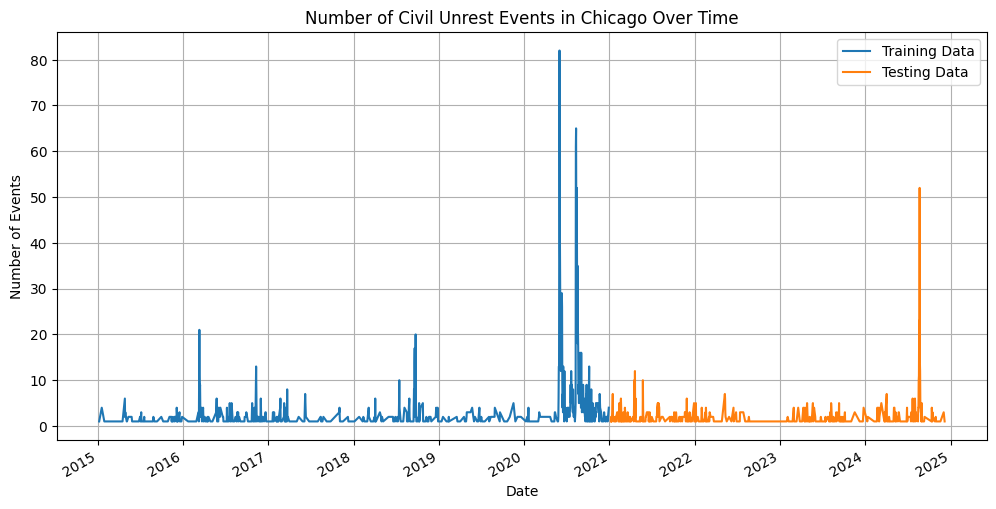

In [31]:
from IPython.display import display

# Display the training data
print("Training Data:")
display(train_data)

# Display the testing data
print("Testing Data:")
display(test_data)
# Plot the number of events over time for training and testing data
plt.figure(figsize=(12, 6))

# Plot training data
train_data.groupby('SQLDATE').size().plot(kind='line', label='Training Data')

# Plot testing data
test_data.groupby('SQLDATE').size().plot(kind='line', label='Testing Data')

plt.title('Number of Civil Unrest Events in Chicago Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
plt.grid(True)
plt.show()

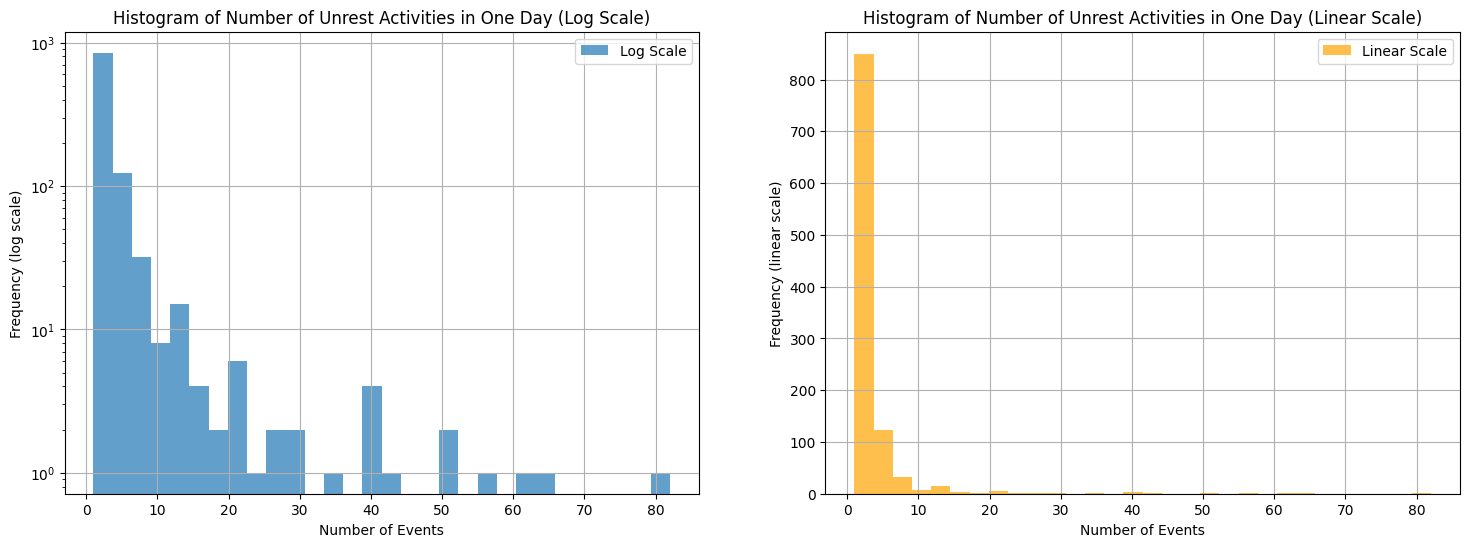

In [34]:
# Group the data by date and count the number of events per day
events_per_day = data.groupby('SQLDATE').size()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot histogram with log scale on the first subplot
ax1.hist(events_per_day, bins=30, alpha=0.7, label='Log Scale')
ax1.set_yscale('log')
ax1.set_xlabel('Number of Events')
ax1.set_ylabel('Frequency (log scale)')
ax1.set_title('Histogram of Number of Unrest Activities in One Day (Log Scale)')
ax1.grid(True)
ax1.legend()

# Plot histogram with linear scale on the second subplot
ax2.hist(events_per_day, bins=30, alpha=0.7, label='Linear Scale', color='orange')
ax2.set_xlabel('Number of Events')
ax2.set_ylabel('Frequency (linear scale)')
ax2.set_title('Histogram of Number of Unrest Activities in One Day (Linear Scale)')
ax2.grid(True)
ax2.legend()

plt.show()


---

# Strategizing how to Use Data